# Linear Regression with Well Log Porosity

In this notebook we will walk through a linear regression using sonic and neutron porosity data from a well log. To do this we need to start by importing `pandas`, `numpy`, `matplotlib`, `lasio`, and `seaborn`. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import lasio
import seaborn as sns; sns.set()
%matplotlib inline

We will read in the `.las` file using `lasio` and convert it to a `DataFrame` that we can use to organize our data. We start by plotting our two features in a scatterplot to get a feel for how similar the two porosity measures are, and where some outliers might exist that could skew our regression. 

Text(0, 0.5, 'Neutron Porosity')

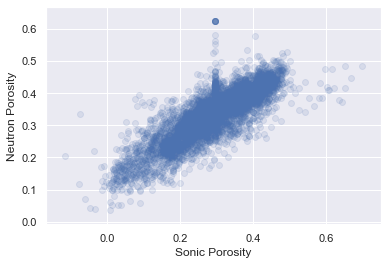

In [2]:
well = lasio.read(r'T13309.las')
dataframe = well.df()
x = dataframe.SPHI.values
y = dataframe.NPOR.values
plt.scatter(x,y, alpha=0.125)
plt.xlabel('Sonic Porosity')
plt.ylabel('Neutron Porosity')

Next we will define the cost function `J` that we want to minimize. $$J = \frac{1}{2m}\sum_{i=1}^{m} (\theta_{0}+\theta_{1}(x^i)-(y^i))^2$$

This function will take our porosity features, along with values of $\Theta_{0}$ and $\Theta_{1}$

In [3]:
# The function J that we want to minimize
def cost_func(x, y, theta_0, theta_1):
    J = 0
    m=len(x)
    for i in range(m):
        J += (1/2*m)*(theta_0 + theta_1*x[i] - y[i])**2
    return J

If we evaluate the `cost_func` for our porosity dataset with theta values both set to zero our cost is `1717156.03`. This is what we want to minimize. We can visualize the cost function as a surface and see where the minima are located

In [4]:
cost_func(x,y,0,0)

1717156.036943275

We use `pcolormesh` and `meshgrid` to plot the cost function as a surface. We want to find the values of $\Theta_{0}$ and $\Theta_{1}$ that have the darkest color (minimum)

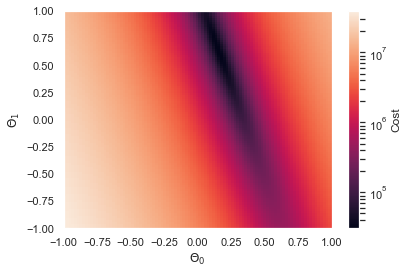

In [5]:
t0 = np.linspace(-1,1, 100)
t1 = np.linspace(-1,1, 100)
tt0, tt1 = np.meshgrid(t0, t1)
cost = cost_func(x, y, tt0, tt1)
plt.pcolormesh(tt0,tt1,cost, norm=colors.SymLogNorm(linthresh=10, linscale=1,
                                              vmin=cost.min(), vmax=cost.max()))
plt.xlabel('$\Theta_{0}$')
plt.ylabel('$\Theta_{1}$')
cbar = plt.colorbar()
cbar.set_label('Cost')

We find this lowest cost by gradient descent. For each iteration, we calculate the cost of $\Theta_{0}$ and $\Theta_{1}$, and the gradient at the current value of $\Theta_{0}$ and $\Theta_{1}$. We then move in the direction of steepest gradient at the rate. Then we update our $\Theta$ values and calculate the gradient at our new location. We do this for however many iterations we want until we have reached a minimum

In [6]:
def linear_regression(X, y, theta_1=0, theta_0=0, iterations=750, rate=0.5):
    theta_zero = []
    theta_one = []
    N = float(len(y))
    for i in range(iterations):
        theta_zero.append(theta_0)
        theta_one.append(theta_1)
        updated_y = theta_0 + (theta_1 * X)
        theta_1_grad = -(2/N) * sum(X * (y - updated_y))
        theta_0_grad = -(2/N) * sum(y - updated_y)
        theta_1 = theta_1 - (rate * theta_1_grad)
        theta_0 = theta_0 - (rate * theta_0_grad)
    return theta_0, theta_1, theta_zero, theta_one

Now we just add in our `x` and `y` porosity arrays and it calculates the optimal values of $\Theta_{0}$ and $\Theta_{1}$ along with the path the gradient descent took

In [7]:
T0, T1, path_t0, path_t1 = linear_regression(x,y)

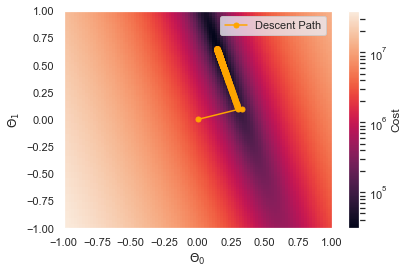

In [8]:
plt.pcolormesh(tt0,tt1,cost, norm=colors.SymLogNorm(linthresh=10, linscale=1,
                                              vmin=cost.min(), vmax=cost.max()))
plt.plot(path_t0, path_t1, c='orange', marker='o', label='Descent Path', markersize=5)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('$\Theta_{0}$')
plt.ylabel('$\Theta_{1}$')
plt.legend()
cbar = plt.colorbar()
cbar.set_label('Cost')

We can use our optimized $\Theta_{0}$ and $\Theta_{1}$ values to plot our regression line with the scatterplot of the data.

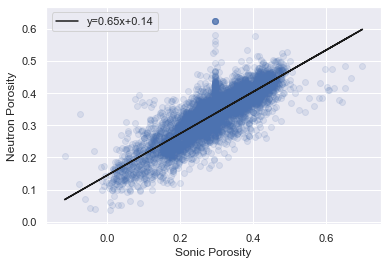

In [9]:
plt.scatter(x,y, alpha=0.125)
plt.plot(x, T0+T1*x, c='k', label='y='+str(round(T1,2))+'x+'+str(round(T0,2)))
plt.xlabel('Sonic Porosity')
plt.ylabel('Neutron Porosity')
plt.legend()

Below it is all combined together so you can visually see how the values of $\Theta_{0}$ and $\Theta_{1}$ change as the algorithm progresses through gradient descent. On the left is the scatter of the data with the linear regression with the $\Theta_{0}$ and $\Theta_{1}$ values from the cost-function space on the right

In [10]:
import ipywidgets as widgets

In [11]:
@widgets.interact(w=(0,len(path_t0)-1,50))
def linear_fit(w):
    f = plt.figure(figsize=(20,10))
    ax = f.add_subplot(121)
    ax1 = f.add_subplot(122)
    ax.plot(x, path_t0[w]+path_t1[w]*x, c='k')
    ax.scatter(x,y, alpha=0.125)
    ax.set_xlim(-0.1,0.8)
    ax.set_ylim(-0.1,0.8)
    ax.set_xlabel('Sonic Porosity')
    ax.set_ylabel('Neutron Porosity')
    ax.text(0.4,0.7,'Y='+str(np.round(path_t0[w],2))+'+'+str(np.round(path_t1[w],2))+'X', fontsize=20)
    ax.set_title('Linear regression')
    
    ax1.pcolormesh(tt0,tt1,cost, norm=colors.SymLogNorm(linthresh=10, linscale=1,
                                              vmin=cost.min(), vmax=cost.max()),zorder=0)
    ax1.plot(path_t0, path_t1, c='orange', marker='o',markersize=5, zorder=1)
    ax1.scatter(path_t0[w], path_t1[w], c='red', s=300, marker='x',zorder=2, label='')

    ax1.set_xlim(min(path_t0),max(path_t0)+0.1)
    ax1.set_ylim(min(path_t1),max(path_t1)+0.1)
    ax1.set_xlabel('$\Theta_{0}$')
    ax1.set_ylabel('$\Theta_{1}$')
    ax1.text(path_t0[w],path_t1[w],'('+str(np.round(path_t0[w],2))+','+str(np.round(path_t1[w],2))+')', 
             fontsize=20, color='red')
    ax1.set_title('Cost Function')

interactive(children=(IntSlider(value=350, description='w', max=749, step=50), Output()), _dom_classes=('widge…

This notebook is licensed as CC-BY, use and share to your hearts content.